<a href="https://colab.research.google.com/github/KeiandraK/DS-Unit-2-Applied-Modeling/blob/master/Keiandra_King_DS_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍔

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [4]:
#Analyzing the data to determine which feature is best to use
train.head(25)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0
5,1725221,LAKEVIEW REHABILITATION AND NURSING CENTER,LAKEVIEW REHABILITATION AND NURSING CENTER,2245580.0,Long Term Care,Risk 1 (High),735 W DIVERSEY PKWY,CHICAGO,IL,60614.0,2016-02-22T00:00:00,Canvass,31. CLEAN MULTI-USE UTENSILS AND SINGLE SERVIC...,41.932632,-87.647973,"{'longitude': '-87.64797278441709', 'latitude'...",0
6,1981372,GOLD COAST DOGS,GOLD COAST DOGS,32318.0,Restaurant,Risk 2 (Medium),225 S CANAL ST,CHICAGO,IL,60606.0,2017-01-12T00:00:00,Canvass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.878531,-87.639427,"{'longitude': '-87.63942745962717', 'latitude'...",0
7,1072403,HAPPY PIZZA,NaN,2241028.0,Restaurant,Risk 1 (High),8710 S HALSTED ST,CHICAGO,IL,60620.0,2013-05-07T00:00:00,License Re-Inspection,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.735505,-87.643749,"{'longitude': '-87.64374906595162', 'latitude'...",0
8,1464616,THE PUMPING CO INC,THE PUMPING CO,1544937.0,Restaurant,Risk 1 (High),6157 N BROADWAY,CHICAGO,IL,60660.0,2014-11-28T00:00:00,Canvass,"16. FOOD PROTECTED DURING STORAGE, PREPARATION...",41.993973,-87.660242,"{'longitude': '-87.66024237516903', 'latitude'...",1
9,583261,YUMMY YUMMY NOODLES,YUMMY YUMMY NOODLES,2098003.0,Restaurant,Risk 1 (High),2002 S WENTWORTH AVE,CHICAGO,IL,60616.0,2011-06-01T00:00:00,License,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.855282,-87.631993,"{'longitude': '-87.63199264229414', 'latitude'...",1


In [0]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [6]:
# Checking for missing values
train.isnull().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [7]:
train.shape, test.shape

((51916, 17), (17306, 17))

In [0]:
train.drop(['Violations','City','State','Zip','AKA Name','Latitude', 'Longitude','Location'],axis = 1, inplace= True)

In [0]:
# First attempt to create pipeline was not sufficient so returned here to drop 
# Another column
train.drop(['Facility Type'],axis=1, inplace = True)

In [0]:
# Second attemp to create pipeline failed 
# Dropping another column in hopes of completion of the pipeline
train.drop(['Risk',],axis = 1, inplace = True)

In [0]:
# Third attempt to create pipeline
# maybe getting rid of all the missing values may be the course of action
train.drop(['License #'], axis = 1, inplace= True)
# Third attempt was successfull 

In [0]:
# Preprocessing all the high nan values away affectively helped pipeline
# Violations was the leakage
# The violations column tells why they failed and this is why it is the leakage

In [28]:
# Do not want to lose some of the important features that help explain the data
train.fillna(method='ffill')
train.isnull().sum().sum()

1

In [29]:
train.head()

,Inspection ID,DBA Name,Address,Inspection Date,Inspection Type,Fail
20735,1158273,ALL FAITH PAVILION,3500 S GILES AVE,2012-04-20T00:00:00,Canvass,1
46561,1234851,PHIL STEFANI SIGNATURE EVENTS,1300 W HUBBARD ST,2012-08-23T00:00:00,Canvass,0
23036,1307709,FADI #3 MINI MART & DELI,1001 W 59TH ST,2014-10-21T00:00:00,License Re-Inspection,0
21866,1464236,Sullivan (H/S),6631 N BOSWORTH AVE,2014-04-22T00:00:00,Canvass Re-Inspection,0
9513,2261822,Brentano,2723 N Fairfield,2019-02-11T00:00:00,Canvass,0


In [0]:
import seaborn as sns
from sklearn.model_selection import train_test_split

target='Fail'
features= train.columns.drop('Fail')

train,val= train_test_split(train, train_size= .80, random_state=2)

In [31]:
train.shape, val.shape

((26580, 6), (6645, 6))

In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [33]:
y_train.value_counts(normalize=True)

0    0.741008
1    0.258992
Name: Fail, dtype: float64

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [0]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

In [35]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_estimators=200, n_jobs = -1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['DBA Name', 'Address', 'Inspection Date',
                                      'Inspection Type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'DBA Name',
                                          'data_type': dtype('O'),
                                          'mapping': SUBWAY 48735                        1
WOODLAWN NEIGHBORHOOD MARKET        2
7-ELEVEN #33496C                    3
MARRIOT MARQUIS CHICAGO             4
CORNERSTONE CAFE                    5
                                ...  
ST. BEN...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        m

In [38]:
# Predicting accuracy score
y_pred = pipeline.predict(X_val)
accuracy_score(y_val,y_pred)

0.7295711060948081

In [39]:
y_val.shape, y_pred.shape, X_val.shape

((6645,), (6645,), (6645, 5))

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_pred_proba = pipeline.predict_proba(X_val)[:,1]

In [41]:
roc_auc_score(y_val, y_pred_proba)

0.6547641700821479

In [42]:
y_pred_proba = pipeline.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_proba)

0.6450494329158302

## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [43]:
train.head()

,Inspection ID,DBA Name,Address,Inspection Date,Inspection Type,Fail
25815,1522678,SUBWAY 48735,317 N DEARBORN ST,2015-02-05T00:00:00,Canvass,0
18627,1975352,WOODLAWN NEIGHBORHOOD MARKET,460 E 61ST ST,2016-11-14T00:00:00,Canvass,0
45088,2081584,7-ELEVEN #33496C,535 S STATE ST,2017-09-06T00:00:00,Canvass,0
23027,2078971,MARRIOT MARQUIS CHICAGO,2121 S PRAIRIE AVE,2017-08-24T00:00:00,License Re-Inspection,0
46194,1441856,CORNERSTONE CAFE,2753 N WESTERN AVE,2015-04-28T00:00:00,Complaint,0


In [45]:
test.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,114835,7 - ELEVEN,7 - ELEVEN,46907.0,Grocery Store,Risk 2 (Medium),600 S DEARBORN,CHICAGO,IL,60605.0,2011-03-22T00:00:00,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.874481,-87.629357,"{'longitude': '-87.62935653990546', 'latitude'...",0
1,1575555,TAQUERIA LOS GALLOS INC,TAQUERIA LOS GALLOS,1044860.0,Restaurant,Risk 1 (High),4209-4211 W 26TH ST,CHICAGO,IL,60623.0,2015-09-15T00:00:00,Canvass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.844070,-87.729807,"{'longitude': '-87.72980747367433', 'latitude'...",0
2,671061,TROTTER'S TO GO,TROTTER'S TO GO,1092634.0,Restaurant,Risk 1 (High),1337 W FULLERTON AVE,CHICAGO,IL,60614.0,2012-03-02T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.925128,-87.662041,"{'longitude': '-87.66204067083224', 'latitude'...",0
3,1965844,BIG G'S PIZZA,BIG G'S PIZZA,2334691.0,Restaurant,Risk 1 (High),1132 W TAYLOR ST,CHICAGO,IL,60607.0,2016-10-04T00:00:00,Canvass Re-Inspection,"14. PREVIOUS SERIOUS VIOLATION CORRECTED, 7-42...",41.869546,-87.655501,"{'longitude': '-87.65550098867566', 'latitude'...",1
4,1751669,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,3491970.0,School,Risk 2 (Medium),1021 E 83RD,CHICAGO,IL,60619.0,2016-04-08T00:00:00,Canvass,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.743933,-87.599291,"{'longitude': '-87.59929083361996', 'latitude'...",1


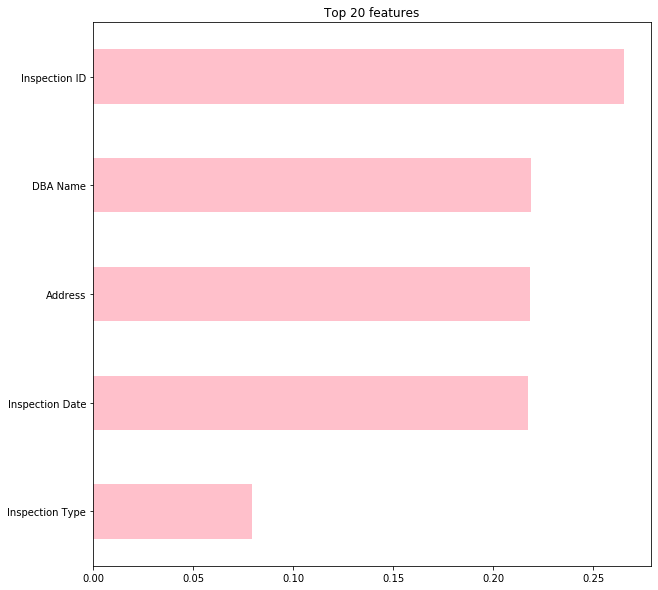

In [99]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='pink');

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

In [55]:
import eli5
from eli5.sklearn import PermutationImportance

preprocessor = ce.OrdinalEncoder()

X_train_transform = preprocessor.fit_transform(X_train)
X_test_transform = preprocessor.transform(X_test)

permuter = PermutationImportance(pipeline, scoring='roc_auc', n_iter=3)
permuter.fit(X_test_transform, y_test)

eli5.show_weights(permuter, top=None, feature_names = features.tolist())

Weight,Feature
0.0393 ± 0.0038,Inspection ID
0 ± 0.0000,Inspection Type
0 ± 0.0000,Inspection Date
0 ± 0.0000,Address
0 ± 0.0000,DBA Name


In [90]:
row = X_train_transform.loc[1]
row

Inspection ID      555268
DBA Name             7927
Address              7476
Inspection Date       128
Inspection Type         7
Name: 1, dtype: int64

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [0]:
pdp_isolate = pdp_isolate(model = pipeline, 
                          dataset = X_train_transform, 
                          model_features = X_train_transform.columns, 
                          feature = 'Inspection ID'
                         )

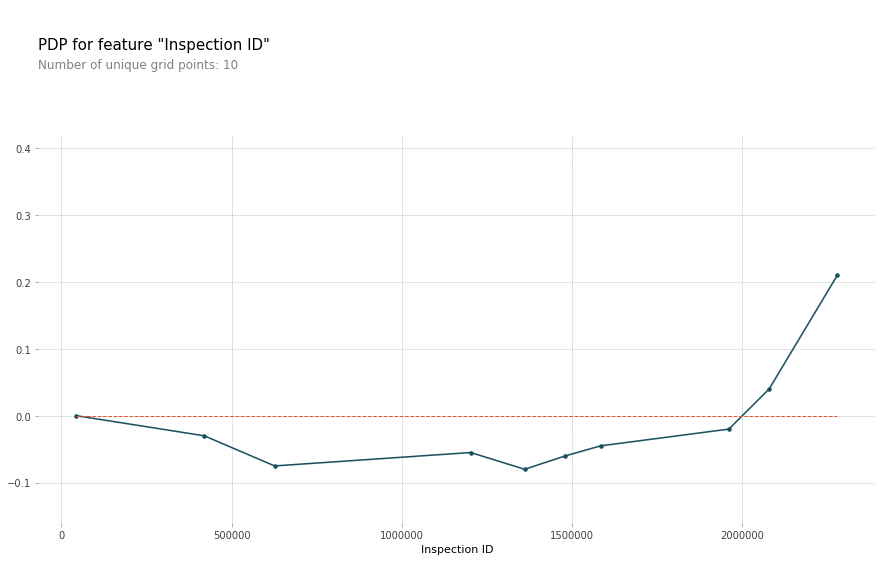

In [81]:
pdp_plot(pdp_isolate, 
         feature_name = 'Inspection ID'
         );

In [0]:
features = ['Inspection Type', 'Inspection ID']
interact = pdp_interact(model = pipeline, 
                          dataset = X_train_transform, 
                          model_features = X_train_transform.columns, 
                          features = features
                         )

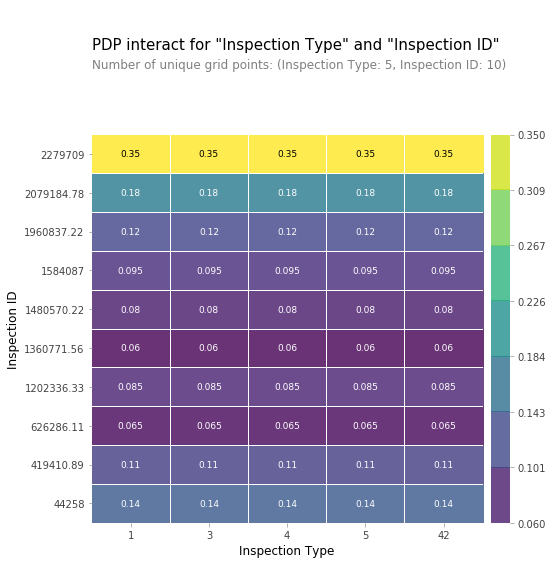

In [84]:
pdp_interact_plot(interact, plot_type = 'grid', feature_names = features);